# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [284]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [231]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [198]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

In [318]:
def plot_loss(loss_history, title):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.plot(loss_history, 'b')
    plt.show()

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

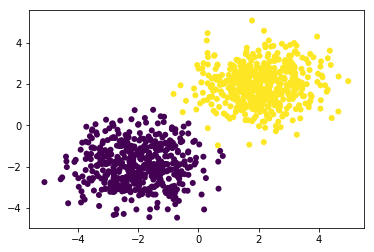

In [199]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [200]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [201]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [202]:
def train(net, criterion, optimizer_config, X, Y,
          batch_size=128, n_epochs=20, hook_fn=None, print_net=True):
    optimizer_state = {}
    loss_history = []
    if print_net:
        print(net)
    net.train()
    for i in range(n_epochs):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)
        if hook_fn is not None:
            hook_fn(i, loss_history, optimizer_config)
    return loss_history

In [319]:
def visualize_hook_fn(epoch, loss_history, optimizer_config):
    display.clear_output(wait=True)
    plot_loss(loss_history, "Training loss")
    print('Current loss: %f' % loss_history[-1])    

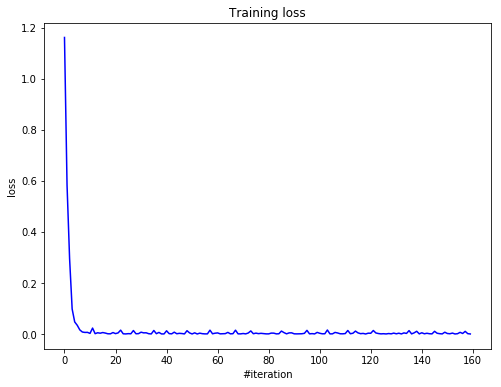

Current loss: 0.000068


In [204]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
_ = train(net, ClassNLLCriterion(), optimizer_config, X, Y, hook_fn=visualize_hook_fn)

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [205]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [206]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
Y = binarizer.fit_transform(y)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [110]:
def build_net(activation_fn, use_bn=False):
    net = Sequential()
    net.add(Linear(784, 256))
    if use_bn:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(256))
    net.add(activation_fn())
    net.add(Linear(256, 256))
    if use_bn:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(256))
    net.add(activation_fn())
    net.add(Linear(256, 10))
    net.add(LogSoftMax())
    return net

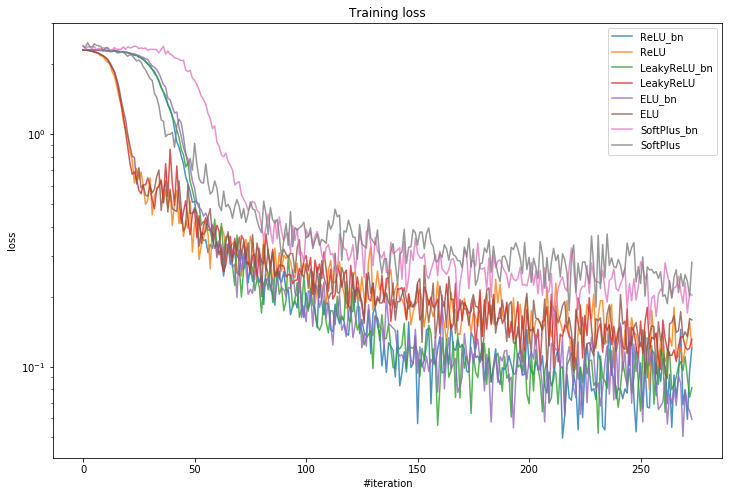

In [122]:
activation_fns = {
    "ReLU": ReLU,
    "LeakyReLU": LeakyReLU,
    "ELU": lambda: ELU(alpha=0.01),
    "SoftPlus": SoftPlus
}

plt.figure(figsize=(12, 8))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.yscale("log")

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
for activation_fn_name, activation_fn in activation_fns.items():
    for use_bn in [True, False]:
        label = activation_fn_name + ("_bn" if use_bn else "")
        net = build_net(activation_fn, use_bn=use_bn)
        loss_history = train(net, ClassNLLCriterion(), optimizer_config, X, Y,
                             n_epochs=4, batch_size=512, print_net=False)
        plt.plot(loss_history, label=label, alpha=0.8)
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Answer**: BatchNormalization helps a lot, as can be clearly observed from the charts. When training starts, BatchNormalized networks do lag behind not normalized ones a little, but as time goes by they start to outperform other networks with a sizable loss gap. 

Among different activation functions, those based on a linear unit (ELU, ReLU, LeakyReLU) are comparable to each other and significantly outperform softplus activation function. 

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
(X_train, X_test,
 Y_train, Y_test,
 y_train, y_test) = train_test_split(X, Y, y, test_size=0.1)

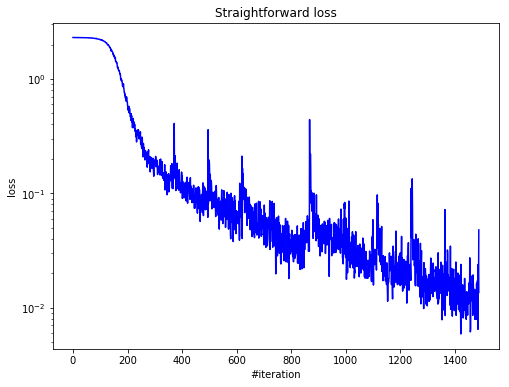

In [355]:
best_clf = Sequential()
best_clf.add(Linear(784, 512))
best_clf.add(BatchNormalization(alpha=0.9))
best_clf.add(ChannelwiseScaling(512))
best_clf.add(ReLU())
best_clf.add(Linear(512, 256))
best_clf.add(BatchNormalization(alpha=0.9))
best_clf.add(ChannelwiseScaling(256))
best_clf.add(ReLU())
best_clf.add(Linear(256, 128))
best_clf.add(BatchNormalization(alpha=0.9))
best_clf.add(ChannelwiseScaling(128))
best_clf.add(ReLU())
best_clf.add(Linear(128, 10))
best_clf.add(LogSoftMax())

optimizer_config = {'learning_rate' : 3e-2, 'momentum': 0.8}
loss_history = train(best_clf, ClassNLLCriterion(), optimizer_config,
                     X_train, Y_train,
                     batch_size=512, n_epochs=12, print_net=False)

plot_loss(loss_history, "Straightforward loss")

Print here your accuracy. It should be around 90%.

In [356]:
print("Test acc:", accuracy_score(y_test, np.argmax(best_clf.forward(X_test), axis=1)))

Test acc: 0.9782857142857143


# Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use `MSECriterion` to score the reconstruction. Use `BatchNormalization` (followed by `ChannelwiseScaling` as usual) between `Linear` and `ReLU`. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [321]:
def build_autoenc_net():
    net = Sequential()
    
    net.add(Linear(784, 512))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(512))
    net.add(ReLU())
    
    net.add(Linear(512, 256))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(256))
    net.add(ReLU())
    
    net.add(Linear(256, 128))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    
    net.add(Linear(128, 30))

    net.add(Linear(30, 128))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(128))
    net.add(ReLU())
    
    net.add(Linear(128, 256))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(256))
    net.add(ReLU())

    net.add(Linear(256, 512))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(512))
    net.add(ReLU())
    
    net.add(Linear(512, 784))
    net.add(ReLU())
    
    return net

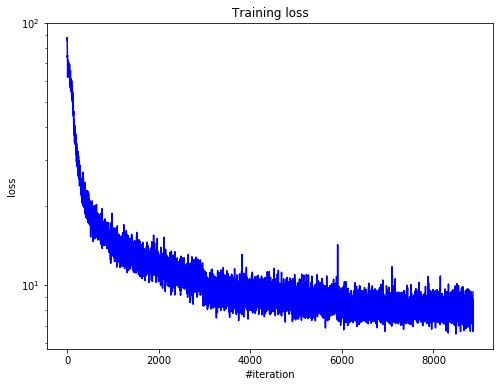

Epoch: 8 loss: 9.39563738897534 lr: 0.0011111111111111111


In [325]:
def hook_fn(epoch, loss_history, optimizer_config):
    display.clear_output(wait=True)
    plot_loss(loss_history, "Training loss")
    print('Epoch: {} loss: {} lr: {}'
          .format(epoch, loss_history[-1], optimizer_config["learning_rate"]))
    if (epoch + 1) % 3 == 0:
        optimizer_config["learning_rate"] /= 3

autoenc = build_autoenc_net()
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.8}
_ = train(autoenc, MSECriterion(), optimizer_config, X_train, X_train,
          hook_fn=hook_fn, batch_size=64, n_epochs=9, print_net=False)

In [326]:
print("Total MSE test loss:", np.mean(np.sum((X_test - autoenc.forward(X_test)) ** 2, axis=1), axis=0))

Total MSE test loss: 6.925273772698434


Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [345]:
autoenc.forward(X_train)
hidden_train = autoenc.modules[12].output
X_test_autoenc = autoenc.forward(X_test)
hidden_test = autoenc.modules[12].output

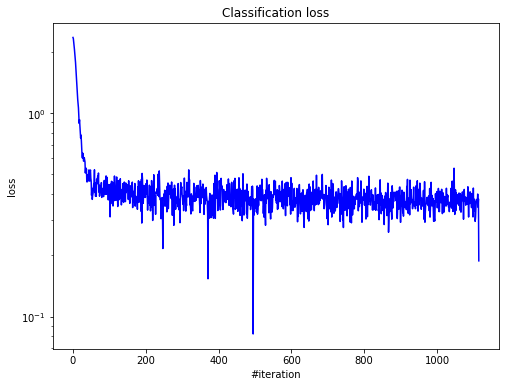

Test score, frozen: 0.8847142857142857


In [330]:
clf = Sequential()
clf.add(Linear(30, 64))
clf.add(Linear(64, 10))
clf.add(LogSoftMax())
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.8}
loss_history = train(clf, ClassNLLCriterion(), optimizer_config, hidden_train, Y_train,
                     batch_size=512, n_epochs=9, print_net=False)

plot_loss(loss_history, "Classification loss")
print("Test score, frozen:", accuracy_score(y_test, np.argmax(clf.forward(hidden_test), axis=1)))

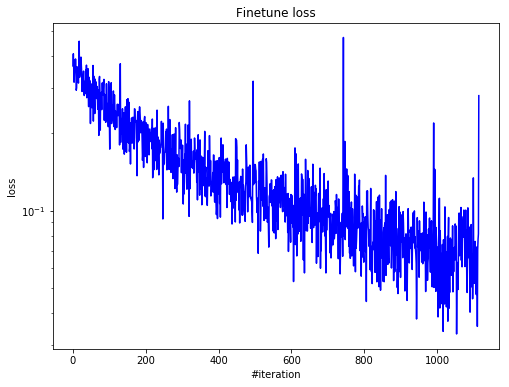

Test score, finetune: 0.9767142857142858


In [331]:
finetune_clf = Sequential(autoenc.modules[:13] + clf.modules)
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.8}
loss_history = train(finetune_clf, ClassNLLCriterion(), optimizer_config, X_train, Y_train,
                     batch_size=512, n_epochs=9, print_net=False)

plot_loss(loss_history, "Finetune loss")
print("Test score, finetune:", accuracy_score(y_test, np.argmax(finetune_clf.forward(X_test), axis=1)))

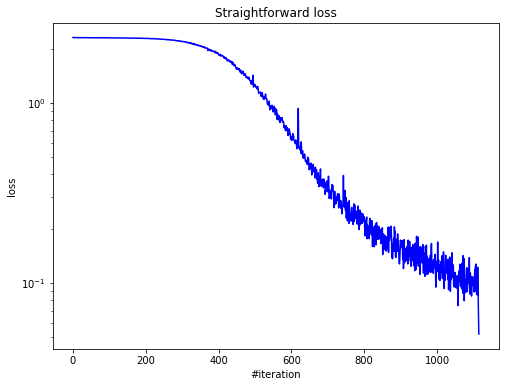

Test score, straightforward: 0.9701428571428572


In [334]:
straightforward_clf = Sequential()
straightforward_clf.add(Linear(784, 512))
straightforward_clf.add(BatchNormalization(alpha=0.9))
straightforward_clf.add(ChannelwiseScaling(512))
straightforward_clf.add(ReLU())
straightforward_clf.add(Linear(512, 256))
straightforward_clf.add(BatchNormalization(alpha=0.9))
straightforward_clf.add(ChannelwiseScaling(256))
straightforward_clf.add(ReLU())
straightforward_clf.add(Linear(256, 128))
straightforward_clf.add(BatchNormalization(alpha=0.9))
straightforward_clf.add(ChannelwiseScaling(128))
straightforward_clf.add(ReLU())
straightforward_clf.add(Linear(128, 10))
straightforward_clf.add(LogSoftMax())

optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.8}
loss_history = train(straightforward_clf, ClassNLLCriterion(), optimizer_config,
                     X_train, Y_train,
                     batch_size=512, n_epochs=9, print_net=False)

plot_loss(loss_history, "Straightforward loss")
print("Test score, straightforward:", accuracy_score(y_test, np.argmax(straightforward_clf.forward(X_test), axis=1)))


* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

**Answer**: 10 years ago this method of iterative stacking may have been the way to go for state of the art systems, but now it's clearly superseded by straightforward end-to-end training (at least for simple tasks like classification, this may not be true for more difficult tasks, like speech recognition or conversational AI). In our case it was comparable to end-to-end training. Among the things that changed during the last decade are exponentially more data available, huge variety of deep learning frameworks, imporved optimization techniques like momentum SGD, RMSProp, AdaGrad, some tricks like BatchNorm, ReLU, ResNet and so on.

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [335]:
from sklearn.decomposition import PCA

In [353]:
pca = PCA(n_components=30)
pca.fit(X_train)
X_test_pcad = pca.inverse_transform(pca.transform(X_test))

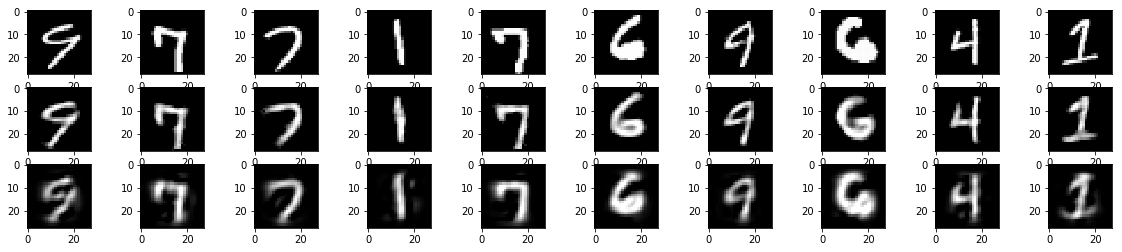

In [357]:
indices = np.random.randint(0, len(X_test), size=(10,))

_, axes = plt.subplots(3, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(X_test[indices[i]].reshape(28, 28), cmap="gray")
    axes[1, i].imshow(np.clip(X_test_autoenc[indices[i]], 0, 1).reshape(28, 28), cmap="gray")
    axes[2, i].imshow(np.clip(X_test_pcad[indices[i]], 0, 1).reshape(28, 28), cmap="gray")
plt.show()

PCA appears to have ghosting effects with remnants of other digits on reconstructed image (this effect is more pronounced with the clipping to [0, 1] region disabled). Both reconstruction techniques appear to output blurry images, but samples from MSE autoencoder are sharper. 